# Setup

In [2]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from itertools import product
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import os

## Defining functions

In [4]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [5]:
def train_test_split(data, train_size, test_size, path):
    train_data = []
    test_data = []
    #train part
    for i in range(train_size):
        name = path + 'm' + str(i + 1) + '.parquet'
        data = pd.read_parquet(name)
        train_data.append(data)
    #test part
    for j in range(test_size):
        name = path + 'm' + str(j + train_size + 1) + '.parquet'
        data = pd.read_parquet(name)
        test_data.append(data)
    return train_data, test_data

In [24]:
def load_data(path, force_update):
    urls = ['https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet',
                'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet',
                'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-03.parquet',
                'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-04.parquet']
    if os.path.exists(path) and (not force_update):
        pass
    else:
        if not os.path.exists(path): 
            os.mkdir(path)
        for index in range(len(urls)):
            response = requests.get(urls[index])
            name = path + 'm' + str(index + 1) + '.parquet'

            with open(name, 'wb') as f:
                f.write(response.content)
    datas = []
    for i in range(len(urls)):
        name = path + 'm' + str(i + 1) + '.parquet'
        data = pd.read_parquet(name)
        data.append(data)

    return datas
    
        
    

In [7]:
def date_format_modifier(data):  # Year/Month/Day
    data['month'] = pd.DataFrame([int(date.strftime("%m")) for date in data['PU_date']])
    data['day_month'] = pd.DataFrame([int(date.strftime("%d")) for date in data['PU_date']])
    data['day_week'] = pd.DataFrame([int(date.weekday()) for date in data['PU_date']])
    data = data.dropna()
    data = data.reindex(columns = ['PU_date', 'PULocationID', 'month','day_month', 'day_week', 'Demand'])
    return data

In [8]:
def add_features(data):  # run after merging datasets and modifing date
    # Lag features
    data['prev_day_demand'] = data.groupby(['PULocationID'])['Demand'].shift(1)

    data = data.dropna()

    return data

In [9]:
def grouping_by(data, group_list):
    data_grouped = data.groupby(group_list, as_index = False)['extra'].count()
    data_grouped = data_grouped.rename(columns={'extra' : 'Demand'})

    return data_grouped

In [10]:
def clearing_data_noise(datas, months):
    clean_datas = []
    for index in range(len(datas)):
        month = months[index]
        data = datas[index]

        clean_data = data[[int(date.strftime("%m")) == month for date in data['tpep_pickup_datetime']]]
        clean_data = clean_data.dropna()
        clean_datas.append(clean_data)
    return clean_datas

In [11]:
def grid_search(model, test_parameters, train_data, cv = None):
    gs = GridSearchCV(estimator = model, param_grid = test_parameters, scoring = 'neg_root_mean_squared_error', cv = cv, n_jobs = -1)
    gs.fit(train_data[train_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [12]:
def point_predict(model, train_data, test_data):

    model.fit(train_data[train_list], train_data['Demand'])


    yhat_train = model.predict(train_data[train_list])
    yhat_test = model.predict(test_data[train_list])

    return yhat_train, yhat_test

In [13]:
def point_predict_visualizer(train_data, test_data, yhat_train, yhat_test):

    predicted_train_df = train_data.copy(deep = True)
    predicted_test_df = test_data.copy(deep = True)
    predicted_train_df['Predicted'] = yhat_train
    predicted_test_df['Predicted'] = yhat_test

    train_data = train_data.groupby('day_year')['Demand'].sum()
    test_data = test_data.groupby('day_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('day_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

In [14]:
def concating_data(datas):
    data_combined = pd.concat(datas, axis=0)
    return data_combined

In [15]:
def evaluation(model_name, train_data, test_data, yhat_train, yhat_test):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_data['Demand'], yhat_train)
    evaluate(mean_squared_error, 'MSE', train_data['Demand'], yhat_train)

    print(f'{model_name} test scores:')


    evaluate(mean_absolute_error, 'MAE', test_data['Demand'], yhat_test)
    evaluate(mean_squared_error, 'MSE', test_data['Demand'], yhat_test)


In [38]:
def day_of_year_modifier(data, year):
    data['day_year'] = 0

    # Loop over each row in the DataFrame
    for index, row in data.iterrows():
        # Get the day and month values from the current row
        day = int(row['day_month'])
        month = int(row['month'])
        
        # Calculate the day number for the current row using datetime
        date = datetime.datetime(year=year, month=month, day=day)
        day_number = (date - datetime.datetime(year=year, month=1, day=1)).days + 1
        
        # Store the day number in the 'day_number' column for the current row
        data.at[index, 'day_year'] = day_number
    return data

In [16]:
def fill_missing_demands(data):
    data = data.reset_index(drop = True)
    
    start_date = data['PU_date'].min()
    end_date = data['PU_date'].max()

    all_loc_dfs = []
    for location_id in range(1, loc_id_num):
        filled_with_zero = pd.DataFrame({'PU_date': pd.date_range(start=start_date, end=end_date), 'PULocationID': location_id})
            
        filled_with_zero['Demand'] = 0
        for i in range(len(filled_with_zero)):
            loc_date_row = data[(data['PU_date']==filled_with_zero['PU_date'][i]) 
                                &(data['PULocationID']==filled_with_zero['PULocationID'][i])]
            if not loc_date_row.empty:
                filled_with_zero['Demand'][i] = loc_date_row['Demand']
                
        all_loc_dfs.append(filled_with_zero)
    filled_data = pd.concat(all_loc_dfs).reset_index(drop=True)
    return filled_data

In [17]:
def keep_date_day(data):
    data['PU_date'] = pd.to_datetime(data.tpep_pickup_datetime.dt.date)
    return data

# initialization and loading dataset

## Constant values

In [18]:
group_list = ['PU_date', 'PULocationID']
train_list = ['month', 'day_month', 'day_week', 'prev_day_demand']
path = 'datasets/'
loc_id_num = 266
year = 2023
train_size = 3
test_size = 1

## Load dataset

In [ ]:
data = load_data(path, force_update = False)

## Train Test Split

In [27]:
train_data, test_data = train_test_split(data, train_size, test_size, path)

# Preprocessing

In [28]:
train_data = clearing_data_noise(train_data, [1,2,3])
test_data = clearing_data_noise(test_data, [4])

In [29]:
train_data_concated = concating_data(train_data)
test_data_concated = concating_data(test_data)

In [30]:
train_data_days = keep_date_day(train_data_concated)
test_data_days = keep_date_day(test_data_concated)

In [31]:
train_grouped = grouping_by(train_data_days, group_list)
test_grouped = grouping_by(test_data_days, group_list)

In [ ]:
train_filled = fill_missing_demands(train_grouped)
test_filled = fill_missing_demands(test_grouped)

In [33]:
train_date_modified = date_format_modifier(train_filled)
test_date_modified = date_format_modifier(test_filled)

In [34]:
train_feature_modified = add_features(train_date_modified)
test_feature_modified = add_features(test_date_modified)

In [ ]:
modified_train = day_of_year_modifier(train_feature_modified, year)
modified_test = day_of_year_modifier(test_feature_modified, year)

# Model Training

## **Ridge Regression**

### Grid search to find best hyper parameters

In [35]:
model = Ridge()
best_params, best_score = grid_search(model, {'alpha':[1, 10, 100, 1000, 1000]}, modified_train, cv = 5)
print(best_params, best_score)

{'alpha': 1000} -203.3550921381187


In [36]:
model = Ridge(**best_params)
yhat_train, yhat_test = point_predict(model, modified_train, modified_test)

### Visualization

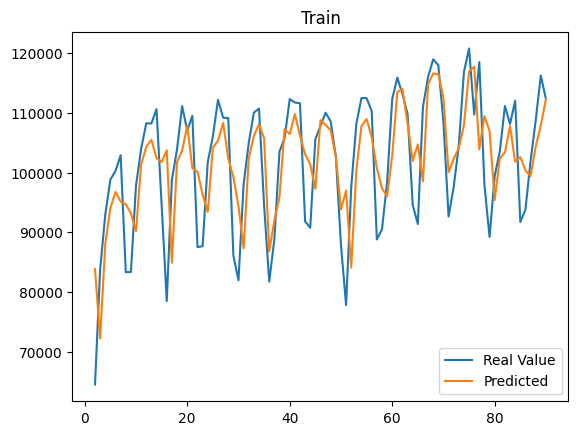

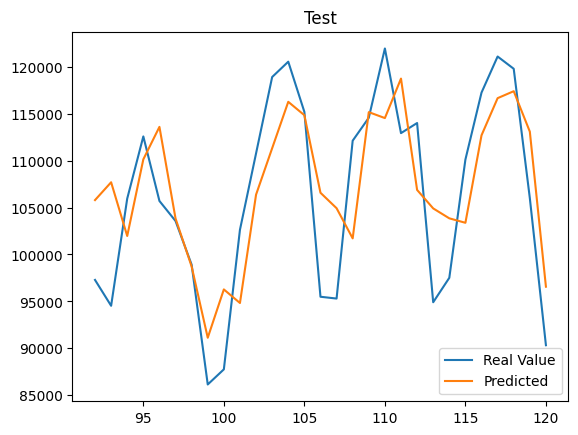

In [40]:
point_predict_visualizer(modified_train, modified_test, yhat_train, yhat_test)

### Evaluation

In [41]:
evaluation('Ridge Regression', modified_train, modified_test, yhat_train, yhat_test)

Ridge Regression train scores:
MAE : 75.93580855076502
MSE : 44937.104300526866
Ridge Regression test scores:
MAE : 76.01415265506068
MSE : 41960.19619701787
